https://www.kaggle.com/thegurusteam/spanish-high-speed-rail-system-ticket-pricing/downloads/spanish-high-speed-rail-system-ticket-pricing.zip/5
goal:  predict price of ticket

At The Gurus, we are working on the following product: this is a Spanish High Speed Train Service (Renfe AVE) tickets pricing monitoring system. It scrapes tickets pricing data periodically and stores it in a database. Ticket pricing changes based on demand and time, and there can be significant difference in price. We are creating this product mainly with ourselves in mind. Users can set up alarms using an email, choosing an origin and destination (cities), time (date and hour range picker) choosing a price reduction over mean price, etc.

### 1 - Importing the Data
first look at the data.  lots of categorical values and dates/times.  

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('renfe.csv', parse_dates=['insert_date','start_date','end_date'])

In [3]:
df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 05:50:00,2019-04-18 08:55:00,AVE,68.95,Preferente,Promo
1,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 06:30:00,2019-04-18 09:20:00,AVE,75.40,Turista,Promo
2,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 07:00:00,2019-04-18 09:30:00,AVE,106.75,Turista Plus,Promo
3,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 07:30:00,2019-04-18 10:40:00,AVE,90.50,Turista Plus,Promo
4,2019-04-11 21:49:46,MADRID,BARCELONA,2019-04-18 08:00:00,2019-04-18 10:30:00,AVE,88.95,Turista,Promo


since so many categorical features, all the features are objects.  remove insert date. that is when the data was scrapped and should have no bearing on the price

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7671354 entries, 0 to 7671353
Data columns (total 9 columns):
insert_date    datetime64[ns]
origin         object
destination    object
start_date     datetime64[ns]
end_date       datetime64[ns]
train_type     object
price          float64
train_class    object
fare           object
dtypes: datetime64[ns](3), float64(1), object(5)
memory usage: 526.8+ MB


In [5]:
df = df.sample(frac = 0.6)

#### 1.1 - Missing Data
There is missing data from the price, train class, and fare.  Since I am trying to predict price, I will delete the rows with missing prices. Removing these missing prices ended up removing the missing values from the other features as well.

In [6]:
print(tabulate([[col, df[col].isnull().sum()/df.shape[0] * 100, df[col].nunique()] for col in df.columns], headers = ['Feature', '% Missing', '# Unique Values']))

Feature        % Missing    # Unique Values
-----------  -----------  -----------------
insert_date     0                    414932
origin          0                         5
destination     0                         5
start_date      0                     19644
end_date        0                     25700
train_type      0                        16
price           7.47906                 327
train_class     0.348874                  9
fare            0.348874                 10


In [7]:
df = df[df['price'].notnull()]

### 2 - Data Exploration
split into two sections: the price and non date features.

#### 2.1 - Price
From the histogram, it seems that most of the ticket prices hover between 45 to 80 Euros.  There are however, tickets that cost as much as 350 Euros, and some are even free!  Using Tukey's method, I found there are 38909 outliers (threshold of 1.5).  Since the distribution is so heavily right skewed, can I take the log of the prices to get more normalized data and reduce the number of outliers?

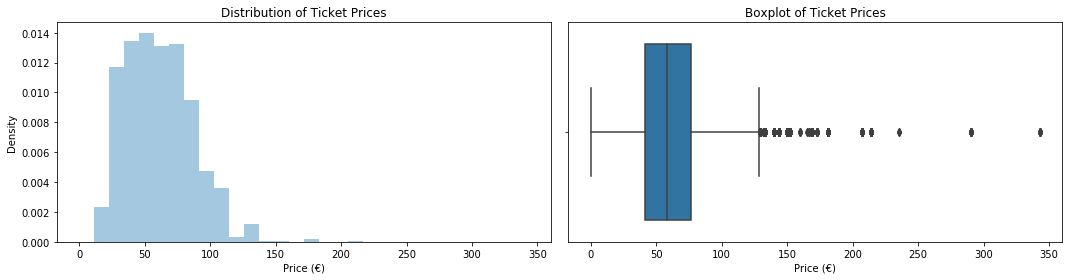

In [8]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15, 4))

sns.distplot(df['price'], bins = 30, kde = False, norm_hist=True, ax = axis1)
sns.boxplot(x = 'price', data = df, ax = axis2)

axis1.set_title('Distribution of Ticket Prices')
axis2.set_title('Boxplot of Ticket Prices')

axis1.set_ylabel('Density')

for ax in [axis1, axis2]:
    ax.set_xlabel('Price (€)')
    
plt.tight_layout()

In [9]:
df['price'].min()

0.0

In [10]:
def get_outlier(dataframe, col, threshold = 1.5):
    q75, q25 = np.percentile(dataframe[col], [75, 25])
    iqr = q75 - q25
    
    minval = q25 - (iqr * threshold)
    maxval = q75 + (iqr * threshold)
    
    print('The number of outliers is {}'.format(len(np.where((dataframe[col] > maxval) | (dataframe[col] < minval))[0])))
    
    return minval, maxval

In [11]:
get_outlier(df, 'price')

The number of outliers is 23184


(-11.449999999999989, 128.94999999999999)

After taking the log of the price, the distribution looks more normalized, centered at 4.  However, there are still ~11k outliers, this time on the lower end of the distribution. 

In [12]:
df['log_price'] = np.log(df['price'] + 1)

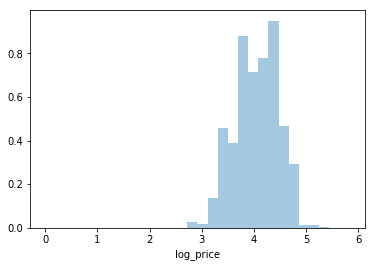

In [13]:
sns.distplot(df['log_price'], kde = False, norm_hist=True, bins = 30)

In [14]:
get_outlier(df, 'log_price')

The number of outliers is 6568


(2.8345096192148507, 5.2556045574204919)

In [15]:
df[df['log_price']==0].head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,log_price
3046677,2019-06-19 19:19:28,BARCELONA,MADRID,2019-06-23 19:00:00,2019-06-23 22:00:00,AVE,0.0,Turista Plus,Flexible,0.0
3073523,2019-06-20 01:51:19,MADRID,BARCELONA,2019-06-24 09:30:00,2019-06-24 12:34:00,AVE,0.0,Preferente,Flexible,0.0
3008284,2019-06-19 09:19:06,BARCELONA,MADRID,2019-06-23 18:00:00,2019-06-23 21:10:00,AVE,0.0,Preferente,Flexible,0.0
4253725,2019-08-19 23:05:22,BARCELONA,MADRID,2019-08-21 18:00:00,2019-08-21 21:10:00,AVE,0.0,Turista Plus,Flexible,0.0
3038186,2019-06-19 17:11:02,BARCELONA,MADRID,2019-06-23 18:00:00,2019-06-23 21:10:00,AVE,0.0,Preferente,Flexible,0.0


#### 2.3 - Non Date Features
The non date features are the origin, destination, train type, class, and fare type.  Each of these are categorical features and will thus have to be converted to numerical values somehow.  But first, lets explore if there is a relationship between each feature and the ticket price.  Since the whole dataset has ~7 million rows, to expedite the plotting process, I will sample a quarter of the original dataset and work with the sample for this section.  The sample is ~1.7 million rows and is enough to capture the behavior of the full dataset.  

##### 2.3.1 - Cities
The most expensive city to travel to and from is Barcelona and the cheapest city is Valencia.  Prices for the origin and destination are similar, with Barcelona's average log price at around 4.4 (or price of €81), and Valencia's average log price at 3.5 (or price of €33).

In [16]:
sample_df = df.sample(frac = 0.25)

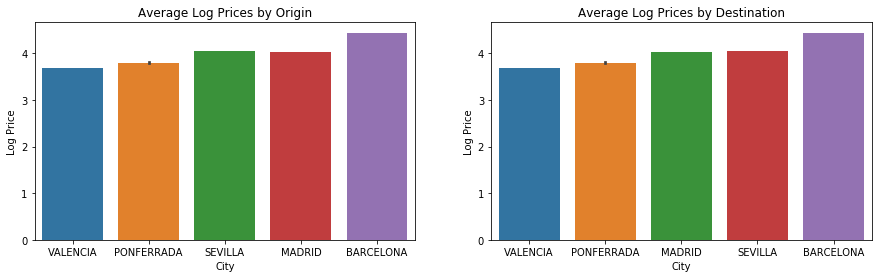

In [17]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x = 'destination', y = 'log_price', 
            order = sample_df.groupby('origin').mean()['log_price'].sort_values().index, data = sample_df, ax = axis1)
sns.barplot(x = 'destination', y = 'log_price', 
            order = sample_df.groupby('destination').mean()['log_price'].sort_values().index, data = sample_df, ax = axis2)

axis1.set_title('Average Log Prices by Origin')
axis2.set_title('Average Log Prices by Destination')

for ax in [axis1, axis2]:
    ax.set_xlabel('City')
    ax.set_ylabel('Log Price')

##### 2.3.2 - Train Type
In this dataset there are 15 unique types of trains that passengers can utilize.  The most expensive type of train is ATE-TGV, a line that operates between Spain and France, and has a average log price of 4.4 (or a price of €86) whereas the cheapest type of train is the regional train, which has a log price of 3.4 (price of €29).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

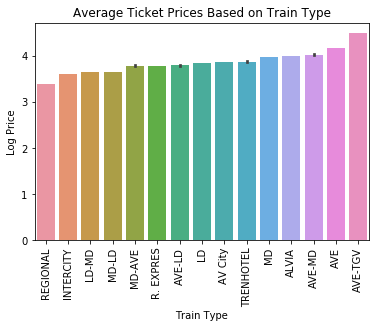

In [19]:
sns.barplot(x = 'train_type', y = 'log_price', order = sample_df.groupby('train_type').mean()['log_price'].sort_values().index,data = sample_df)
plt.title('Average Ticket Prices Based on Train Type')
plt.xlabel('Train Type')
plt.ylabel('Log Price')
plt.xticks(rotation='vertical')

##### 3.2.3 - Train Class
The cheapest class is called turista con enlace.  I'm not fluent in Spanish, but I believe this means there is a stop/transfer point for this type of class.  The average log price for this class is 3.8 (price of €43).  On the other hand, the most expensive class is called Cama G. Clase, which looks like comes with a bed, toilet and shower and comes at a log price of 5 (price of €147).

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

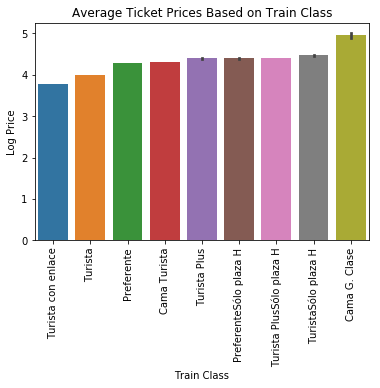

In [20]:
sns.barplot(x = 'train_class', y = 'log_price', order = sample_df.groupby('train_class').mean()['log_price'].sort_values().index, data = sample_df)
plt.title('Average Ticket Prices Based on Train Class')
plt.xlabel('Train Class')
plt.ylabel('Log Price')
plt.xticks(rotation='vertical')

##### 3.2.4 - Fare
The first thing to notice is that there is seemingly no data for the fare type '4x100'.  This is because the fare is 0.  In the complete dataset, there is only one instance of this type of fare as well, so I will drop it as it appears to be an outlier.  

The cheapest fare is called adulto ida, which is an adult outbound/one way ticket.  The average log price for this fare is 3.5 (price of €32).  The most expensive fare is mesa, which means the passenger is seated at a table.  The average log price for having a table is 5.5 (price of €246), quite a bit more expensive than the adult one way ticket.  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

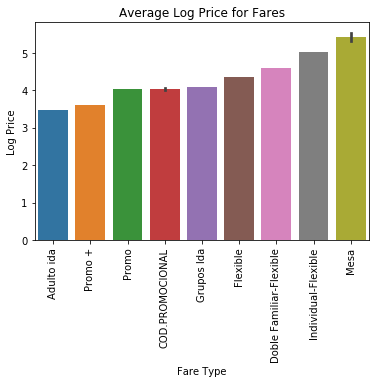

In [21]:
sns.barplot(x = 'fare', y = 'log_price', order = sample_df.groupby('fare').mean()['log_price'].sort_values().index, data = sample_df)
plt.title('Average Log Price for Fares')
plt.xlabel('Fare Type')
plt.ylabel('Log Price')
plt.xticks(rotation='vertical')

In [22]:
df = df[df['fare'] != '4x100']

In [23]:
# df.to_csv('renfe_2.csv', index = False)

### 4 - Feature Engineering
Thus far, there hasn't been many numerical features.  For this dataset, all of the numerical features will be derived from the datetime columns.  In addition, a very important feature missing from the dataset is the route, which is can be used as a proxy for distance.

#### 4.1 - Deriving Features from Dates
All the trips in this dataset occur in 2019, so I will not be including a year.  From the starting date, I can immediately derive the month, hour, and minute the trip starts.  Again, for computational purposes, I will be plotting each graph with a sample of the whole population.  

The start date of all trips are in the range of April to October 2019.  It appears that as the year goes on, the log prices decreases.  As for the hour, average prices seem to be relatively steady between 8am and 5pm.  The other hours are a little more erratic, but generally the prices are lower in the middle of the night.  Last is the minutes.  I'm surprised that the trips don't start on a more regular schedule (i.e. on the hour or every fifteen minutes).  Nevertheless, there does seem to be a vaguely cyclical cycle where the log of the price peaks near the hour (55-5) and near the half hour (between 25-35).  

In [24]:
df['month'] = df['start_date'].apply(lambda x: x.month)
df['hour'] = df['start_date'].apply(lambda x: x.hour)
df['minute'] = df['start_date'].apply(lambda x: x.minute)

In [25]:
sample_df = df.sample(frac = 0.25)

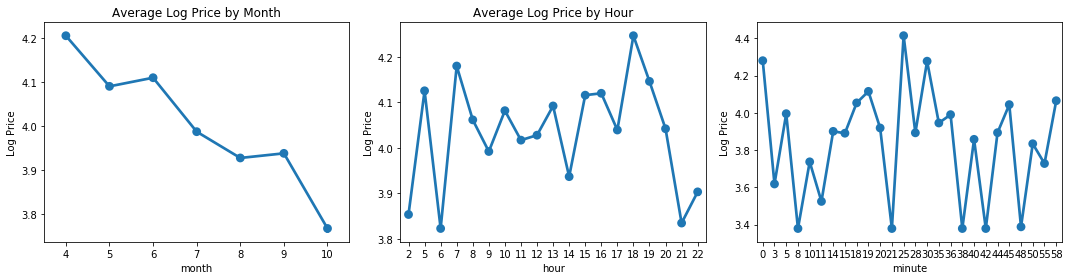

In [26]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))

sns.pointplot(x = 'month', y = 'log_price', data = sample_df, ax = axis1)
sns.pointplot(x = 'hour', y = 'log_price', data = sample_df, ax = axis2)
sns.pointplot(x = 'minute', y = 'log_price', data = sample_df, ax = axis3)

axis1.set_title('Average Log Price by Month')
axis2.set_title('Average Log Price by Hour')
for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Log Price')
    
plt.tight_layout()

From the month, hour and minutes, I can extract even more features.  From the months, I can extract seasons, in which I define spring as April and May, summer is June - August, and autumn is September - October.  Lastly, from the minutes, I'm curious if there is any relationship between the price and the trip starting near the hour and half hour.

In [27]:
def get_seasons(col):
    if col <= 5:
        return 'spring'
    if 6 <= col <= 8:
        return 'summer'
    if col >= 9:
        return 'autumn'

In [28]:
df['season'] = df['month'].apply(get_seasons)

In [29]:
def get_part_of_day(col):
    if col <=6 or col >=21:
        return 'night'
    if 7 <= col < 12:
        return 'morning'
    if 12 <= col < 17:
        return 'afternoon'
    if 17 <= col < 21:
        return 'evening'

In [30]:
df['part_of_day'] = df['hour'].apply(get_part_of_day)

In [31]:
def get_top_of_hour(col):
    if col < 3:
        return 1
    if col > 55:
        return 1
    else:
        return 0

In [32]:
def get_half_hour(col):
    if 25 <= col <= 35:
        return 1
    else:
        return 0

In [33]:
df['top_of_hour'] = df['minute'].apply(get_top_of_hour)
df['half_hour'] = df['minute'].apply(get_half_hour)

The rest of the features that can be derived from the date involve subtracting two dates/times.  Three examples that come to mind include calculating the duration of the trip, if the trip is overnight, and how long between the 'booking' of the trip until the day of the actual trip?  In this case, the booking of the trip is when the data was scrapped.  

In [34]:
df['duration'] = df['end_date'] - df['start_date']

In [35]:
df['overnight'] = df['start_date'].apply(lambda x: x.day) != df['end_date'].apply(lambda x: x.day)

In [36]:
df['booking_to_trip'] = (df['start_date'] - df['insert_date']).apply(lambda x: x.days)

#### 4.2 - Deriving Routes
The last feature I'd like to extract is the route.  This is done simply by combining the starting and ending cities.  Luckily since there are only 5 cities, the number of unique routes is 8.  

In [37]:
df['route'] = df['origin'] + ' - ' + df['destination']

### OLS 
The first model I'd like to test is an OLS regression model.  However, before I can do that, I must prep the data so that all features are numerical and remove any features that are redundant.  



In [38]:
df.drop(['insert_date', 'origin', 'destination', 'start_date', 'end_date'], axis = 1, inplace = True)

In [43]:
num_col = [col for col in df.columns if df[col].dtype != 'object']

In [44]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']

In [46]:
dummy_df = pd.DataFrame()
for col in cat_col:
     dummy_df = pd.concat([dummy_df, pd.get_dummies(df[col], prefix = col, drop_first=True)], axis = 1)

In [47]:
df_ols = pd.concat([df, dummy_df], axis = 1)

y_ols = df_ols['log_price']
X_ols = df_ols.drop(['log_price', 'price'], axis = 1)


In [ ]:
X_ols_train, X_ols_test, y_ols_train, y_ols_test = train_test_split(X_ols, y_ols, test_size=0.2, random_state=42)
X_ols_train = sm.add_constant(X_ols_train)
X_ols_test = sm.add_constant(X_ols_test)

In [ ]:
results_ols = sm.OLS(y_ols_train, X_ols_train).fit()
print(results_ols.summary())